# Read in the data

In [35]:
import pandas as pd
import numpy
import numpy as np
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [36]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [37]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [38]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [39]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [40]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [41]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [42]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [43]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [44]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline


In [46]:
print(survey_fields)
combined.columns
combined.corr()['sat_score']

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64

# To delete



`dbn	School identification code (district borough number)
sch_type	School type (Elementary, Middle, High, etc)
location	School name
enrollment	Enrollment size
borough	Borough
principal	Principal name
studentsurvey	Only students in grades 6-12 partipate in the student survey. This field indicates whether or not this school serves any students in grades 6-12.
rr_s	Student Response Rate
rr_t	Teacher Response Rate
rr_p	Parent Response Rate
N_s	Number of student respondents
N_t	Number of teacher respondents
N_p	Number of parent respondents
nr_s	Number of eligible students
nr_t	Number of eligible teachers
nr_p	Number of eligible parents
saf_p_10	Safety and Respect score based on parent responses
com_p_10	Communication score based on parent responses
eng_p_10	Engagement score based on parent responses
aca_p_10	Academic expectations score based on parent responses
saf_t_10	Safety and Respect score based on teacher responses
com_t_10	Communication score based on teacher responses
eng_t_10	Engagement score based on teacher responses
aca_t_10	Academic expectations score based on teacher responses
saf_s_10	Safety and Respect score based on student responses
com_s_10	Communication score based on student responses
eng_s_10	Engagement score based on student responses
aca_s_10	Academic expectations score based on student responses
saf_tot_10	Safety and Respect total score
com_tot_10	Communication total score
eng_tot_10	Engagement total score
aca_tot_10	Academic Expectations total score`


# Exploring safety

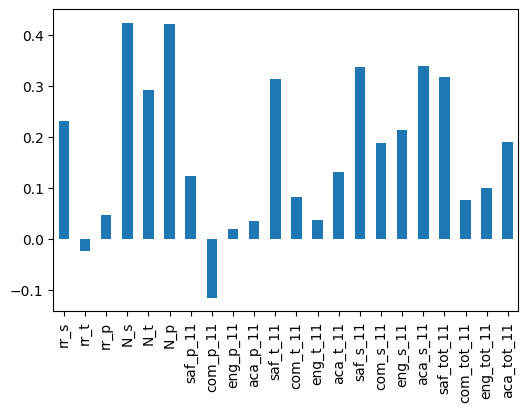

In [47]:
combined.corr()['sat_score'][survey_fields].plot.bar()
plt.show()

Looking at the correlation graph we see that the most significant correlation is between the `sat score` and the following three columns `N_p`, `N_t` and `N_s`.

Another interesting positive correlation is with the `rr-s` which is the student response rate. There is a positive correlation between the two, as percentage of students who completed the survey are more likely to be better educated and to have better SAT scores.

There are also two more columns which correlate positively with `sat_score`, there are the `saf_t_11` and `saf_s_11`, there are safety and respect score that was given from the teachers and students. As expected, both teachers and students value a safety environment. Thus teaching and learning processes are much easier and better in a more safe and respectful environment.

Lastly, there is also a positive correlation between `aca_s_11` and `sat_score`. These are the scores for the academic expectations based on student responses. However, these differ with the responses from the teachers and parents - `aca_p_11` and `aca_t_1`. Teachers and parents perceive academic standards differently and these scores show weak correlated with `sat_score`, as opposed to how students have rated safety at their schools.

In [48]:
tc = ['saf_t_11', 'saf_s_11']
combined.corr()['sat_score'][['saf_t_11', 'saf_s_11']]

saf_t_11    0.313810
saf_s_11    0.337639
Name: sat_score, dtype: float64

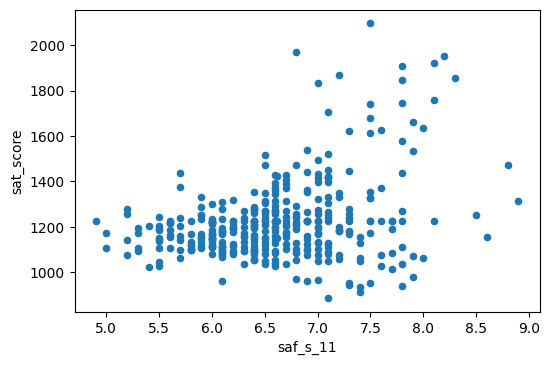

In [49]:
combined.plot.scatter('saf_s_11', 'sat_score')

Looking furthe into the school safety, we see that there is no school where safety score is less than 6.5 and the SAT score is higher than 1500.

# Borough safety

In [50]:
grouped = combined.groupby('boro').agg(np.mean)['saf_s_11']
grouped.head(10)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64

From the five boroughs in New York, Manhattan and Queens have the highest school safely scores. Brooklyn is at the bottom of the table with the lowest score of 6.3.

In [51]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']

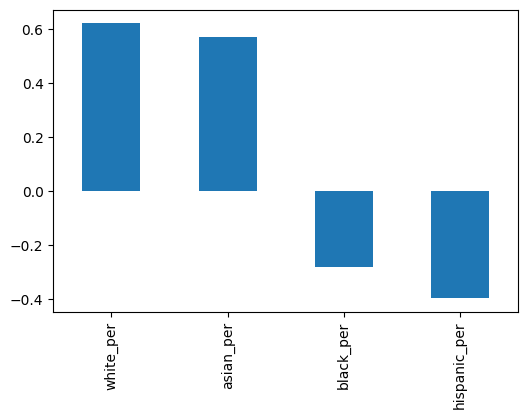

In [52]:
combined.corr()['sat_score'][races].plot.bar()

We see that there is a strong correlation between the race and `sat_score`. Graph above shows a positive relationship between the white and asian students with SAT scores. And on the opposite, we see a medium negative correlation between black and hispanic students and `sat_score`. This may be due to a various reasons one of which might be a lack of funding for certain regions and schools.

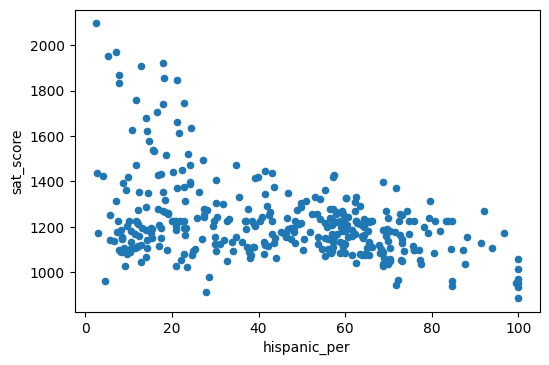

In [53]:
combined.plot.scatter('hispanic_per', 'sat_score')

In the graph above we see that in schools with hispanic presence of 40% and more sat score is between 1100 and 1400. 

Below we will look into schools that have over 95% hispanic students.

In [54]:
hispanic_per_95 = combined[combined['hispanic_per'] > 95]
hispanic_per_95[['SCHOOL NAME', 'sat_score']]

,SCHOOL NAME,sat_score
44,MANHATTAN BRIDGES HIGH SCHOOL,1058.0
82,WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL,1174.0
89,GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...,1014.0
125,ACADEMY FOR LANGUAGE AND TECHNOLOGY,951.0
141,INTERNATIONAL SCHOOL FOR LIBERAL ARTS,934.0
176,PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE,970.0
253,MULTICULTURAL HIGH SCHOOL,887.0
286,PAN AMERICAN INTERNATIONAL HIGH SCHOOL,951.0


Schools where hispanic students are over 95%, are for students who are learning English and it is not their mother languge. This explains the lower SAT score.

In [55]:
hispanic_per_10 = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)]

In [56]:
hispanic_per_10['SCHOOL NAME']

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object

We decided to investigate further but this time our data contains schools where hispanic students are less than 10% and `sat_score` is over 1800. Looking at the table above we see that all the schools which fall under our selected criteria are technical high schools. These are schools where they teach extensive science and technical curriculum like mathematics, physics, chemistry etc. There are also entrance examinations in each of these schools, so students are pre-selected. Our figures do not explain why the hispanic students are a minority, but explain very well why students tend to do better in SAT.

## Gender Differencies and SAT scores

We will try and see if gender plays a role in SAT scores. 
To answer this, we are going to plot a correlations graph and see if `sat_score` is correlated with female and male students.

,female_per,male_per
0,38.6,61.4
1,42.6,57.4
2,45.3,54.7
3,53.7,46.3
4,50.8,49.2
...,...,...
358,47.9,52.1
359,51.6,48.4
360,45.5,54.5
361,47.9,52.1


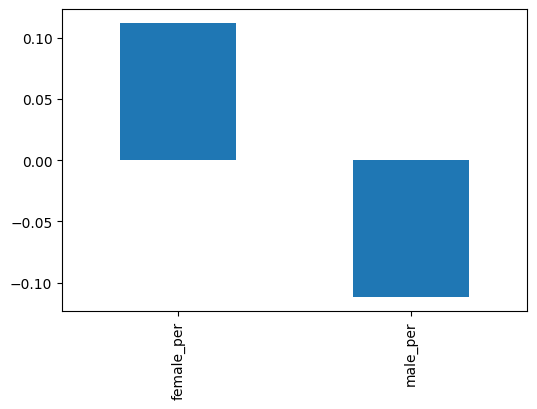

In [57]:
genders = ['female_per', 'male_per']
combined.corr()['sat_score'][genders].plot.bar()

combined[genders]

As the graph shows there is a week correlation between the genders, or at least the differences are small, and they can be considered insignificant. Female students tend to get little bit higher scores than male students, but in general the two gender groups are on par with sat scores.

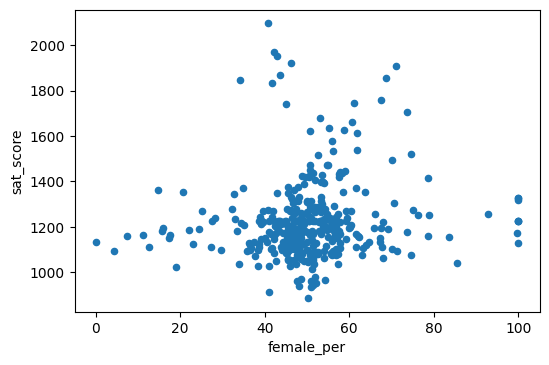

In [58]:
combined.plot.scatter('female_per','sat_score')

Above graph shows that schools with higher number of female students from 40% - 70% have SAT score between 1100 and 1500.

Looking further into gender specifics in SAT scores we are going to examine schools where female students are over 60% and SAT score is greater than 1700.

In [59]:
female_per_60 = combined[(combined['female_per'] > 60) & (combined['sat_score'] > 1700)]
female_per_60[['SCHOOL NAME', 'sat_score', 'female_per']]

,SCHOOL NAME,sat_score,female_per
5,BARD HIGH SCHOOL EARLY COLLEGE,1856.0,68.7
26,ELEANOR ROOSEVELT HIGH SCHOOL,1758.0,67.5
60,BEACON HIGH SCHOOL,1744.0,61.0
61,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,1707.0,73.6
302,TOWNSEND HARRIS HIGH SCHOOL,1910.0,71.1


Above table indicates very good SAT results and a percentage of female students greater than 60%. Schools in the table are selective liberal schools with great academic standards.

## Advanced Placement and SAT exams.

In the U.S., high school students take Advanced Placement (AP) exams to earn college credit. There are AP exams for many different subjects.
It makes sense that the number of students at a school who took AP exams would be highly correlated with the school's SAT scores. 
Thus, we are going to examine if there is a relationship between the two using a correlation method again.

We will look at the percentage of students in each school who took at least one AP exam, as total `total_enrollment` is highly correlated with `sat_score` and we do not want to lead to bias results.

In [60]:
combined['ap_per'] = (combined['AP Test Takers '] / combined['total_enrollment']) * 100
combined['ap_per']

0      30.575556
1       9.898477
2       3.177258
3      35.157724
4      15.809051
         ...    
358     7.755776
359    29.730149
360    19.095477
361     2.661597
362     7.359307
Name: ap_per, Length: 363, dtype: float64

To illustrate this we will use a scatter plot of the `ap_per` and `sat_score`.

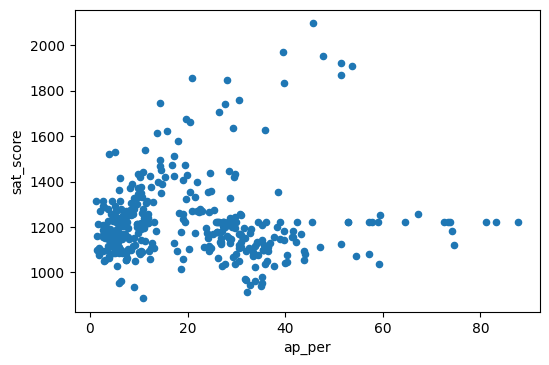

In [61]:
combined.plot.scatter('ap_per', 'sat_score')

The graph clearly indicates that there is no correlation between the `ap_per` and `sat_score`. Even if we look at schools where more than 50% took an advanced placement, we do not see a correlation as the average SAT score is between 1000 and 1400 accross the whole figure.

# Conclusion, and Key Takeaways

After reviewing various types of data based on location, gender, race, safety etc...
We see a correlation between SAT scores and race. This tells us that some race groups tend to do better than others. Here, some next steps could be taken toward reducing this gap, for example:
* Introducing extra teaching hours and curriculum on subjects for the SAT.
* Taking pre-exam tests to find parts of the test where students tend to do worse. Creating a focus group of students who struggle with a given subject and material at school.

Another, factor that relates positively with SAT score is the safety, we learned that students tend to do better in SAT if the school environment where they study is safe. 
* It is possible to introduce more tight school laws and to ensure students follow these.

Lastly, there are some factors that have minimal effect or no effect on SAT scores at all, advanced placement for example, or gender. These, columns show weak correlation with SAT scores, thus, we can safely say that these factors are not that important to SAT scores.